## Calibrating rough Bergomi parameter using Bayesian inference approach

This script requires a pretrained neural network that predicts implied volatility. 

The main engine for Bayesian inference is No-U-Turn Samplers (NUTS) using Numpyro in JAX.

In [2]:
import os

import corner
import einops
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm


def load_rbergomi(
    data_path="../data/rbergomi_data_100000.csv",
):
    data_df = pd.read_csv(data_path)
    data_df = data_df.dropna()

    X = data_df[["hurst", "rho", "eta", "xi", "moneyness", "maturity"]].to_numpy()
    y = data_df["implied_vol"].to_numpy()

    len_X = X.shape[0]
    len_train = int(0.8 * len_X)
    len_valid = int(0.1 * len_X)

    X_train, y_train = X[:len_train], y[:len_train]
    X_valid, y_valid = (
        X[len_train : len_train + len_valid],
        y[len_train : len_train + len_valid],
    )
    X_test, y_test = X[len_train + len_valid :], y[len_train + len_valid :]

    return {
        "train": (X_train, y_train),
        "test": (X_test, y_test),
        "valid": (X_valid, y_valid),
    }


def main(
    model_path="../checkpoint/best_model.eqx",
    spx_data_path="../data/spx/",
    rbergomi_data_path="../data/rbergomi_data_100000.csv",
    # neural network
    width_size=64,
    depth=10,
    seed=123,
    # numpyro parameters
    num_samples=500,
    num_warmup=200,
):
    key = jrandom.PRNGKey(seed)
    data = load_rbergomi(data_path=rbergomi_data_path)
    X_train, _ = data["train"]
    X_mean = jnp.mean(X_train, axis=0, keepdims=True)
    X_std = jnp.std(X_train, axis=0, keepdims=True)

    model = eqx.nn.MLP(
        in_size=X_train.shape[-1],
        width_size=width_size,
        depth=depth,
        out_size=1,
        key=jrandom.PRNGKey(0),  # dummy key
    )

    model = eqx.tree_deserialise_leaves(model_path, model)

    def numpyro_model(moneyness_maturity, implied_vol, sigma):

        hurst = numpyro.sample(
            "hurst", dist.TruncatedNormal(loc=0.07, scale=0.05, low=0.01, high=0.5)
        )
        eta = numpyro.sample(
            "eta", dist.TruncatedNormal(loc=2.5, scale=0.5, low=1.0, high=4.0)
        )
        rho = numpyro.sample(
            "rho", dist.TruncatedNormal(loc=-0.95, scale=0.2, low=-1.0, high=-0.5)
        )
        xi_sqrt = numpyro.sample(
            "xi_sqrt", dist.TruncatedNormal(loc=0.3, scale=1.0, low=0.05, high=1)
        )

        n_data = moneyness_maturity.shape[0]
        # "hurst", "rho", "eta", "xi", "moneyness", "maturity"
        mu = jnp.stack([hurst, rho, eta, xi_sqrt**2])
        mu = einops.repeat(mu, "a -> n_data a", n_data=n_data)
        features = jnp.concatenate([mu, moneyness_maturity], axis=-1)

        features = (features - X_mean) / X_std

        mean = jax.vmap(model)(features)
        mean = jnp.squeeze(mean)
        numpyro.sample(
            "obs",
            dist.Independent(
                base_dist=dist.Normal(loc=mean, scale=sigma),
                reinterpreted_batch_ndims=0,
            ),
            obs=implied_vol,
        )

    for month in tqdm(range(1, 13), desc="month"):

        spx_df = pd.read_csv(os.path.join(spx_data_path, f"parsed_call_{month}.csv"))

        spx_df = spx_df.dropna()
        spx_df = spx_df[spx_df.Spread > 0]
        weight = spx_df.Weight.to_numpy()
        sigma = 1.0 / spx_df.Spread.to_numpy()
        maturity = spx_df["Time to Maturity (years)"].to_numpy()
        # moneyness here is set to K/S0
        moneyness = spx_df.Strike.to_numpy() / spx_df.Spot.to_numpy()
        implied_vol = spx_df["Implied Vol"]

        weight = jnp.array(weight, dtype=jnp.float32)
        sigma = jnp.array(sigma, dtype=jnp.float32)
        maturity = jnp.array(maturity, dtype=jnp.float32)
        moneyness = jnp.array(moneyness, dtype=jnp.float32)
        implied_vol = jnp.array(implied_vol, dtype=jnp.float32)

        # tweak sigma
        sigma = jnp.sqrt(weight) * sigma
        sigma = sigma / jnp.max(sigma)

        # build Numpyro model
        kernel = NUTS(numpyro_model)

        mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
        mcmc.run(
            rng_key=jrandom.fold_in(key, month),
            moneyness_maturity=jnp.stack([moneyness, maturity], axis=-1),
            implied_vol=implied_vol,
            sigma=sigma,
        )
        mcmc.print_summary()
        samples_1 = mcmc.get_samples()

        np_samples = np.array(jnp.stack(list(samples_1.values()), axis=-1))
        corner.corner(
            np_samples,
            bins=20,
            quantiles=[0.05, 0.95],
            labels=[r"$\eta$", r"$H$", r"$\rho$", r"$\xi$"],
            show_titles=True,
        )

sample: 100%|██████████| 700/700 [00:09<00:00, 76.49it/s, 7 steps of size 5.22e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.27      0.02      2.27      2.23      2.30    438.93      1.00
     hurst      0.07      0.00      0.07      0.07      0.07    419.67      1.00
       rho     -0.86      0.01     -0.86     -0.87     -0.85    448.42      1.00
   xi_sqrt      0.05      0.00      0.05      0.05      0.05    236.61      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:09<00:00, 77.74it/s, 7 steps of size 5.93e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.28      0.02      2.29      2.24      2.31    288.44      1.01
     hurst      0.07      0.00      0.07      0.07      0.07    290.12      1.00
       rho     -0.84      0.01     -0.84     -0.85     -0.83    220.60      1.01
   xi_sqrt      0.05      0.00      0.05      0.05      0.05    352.19      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:11<00:00, 61.18it/s, 7 steps of size 2.13e-01. acc. prob=0.93]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.51      0.02      2.50      2.48      2.53    189.91      1.00
     hurst      0.05      0.00      0.05      0.05      0.05    191.88      1.01
       rho     -0.76      0.00     -0.76     -0.76     -0.75    227.58      1.00
   xi_sqrt      0.38      0.00      0.38      0.38      0.38    214.49      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:08<00:00, 79.88it/s, 3 steps of size 4.58e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.23      0.01      2.24      2.21      2.25    392.69      1.00
     hurst      0.05      0.00      0.05      0.05      0.05    287.91      1.00
       rho     -0.84      0.00     -0.84     -0.84     -0.83    237.32      1.00
   xi_sqrt      0.05      0.00      0.05      0.05      0.05    454.58      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:18<00:00, 36.88it/s, 15 steps of size 2.08e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.21      0.03      2.21      2.16      2.25    174.61      1.00
     hurst      0.06      0.00      0.06      0.06      0.07    279.50      1.00
       rho     -0.85      0.01     -0.85     -0.86     -0.84    124.03      1.02
   xi_sqrt      0.27      0.00      0.27      0.27      0.28    237.95      1.01

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:13<00:00, 53.05it/s, 15 steps of size 1.71e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      3.14      0.01      3.14      3.13      3.15    307.52      1.00
     hurst      0.03      0.00      0.03      0.02      0.03    207.01      1.00
       rho     -0.75      0.00     -0.75     -0.75     -0.75    218.39      1.00
   xi_sqrt      0.47      0.00      0.47      0.47      0.47    372.16      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:09<00:00, 76.29it/s, 7 steps of size 4.74e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.32      0.01      2.32      2.30      2.34    482.83      1.00
     hurst      0.07      0.00      0.07      0.07      0.07    493.69      1.00
       rho     -0.84      0.00     -0.84     -0.85     -0.83    459.27      1.00
   xi_sqrt      0.05      0.00      0.05      0.05      0.05    251.48      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:07<00:00, 90.56it/s, 7 steps of size 3.51e-01. acc. prob=0.87]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.21      0.01      2.21      2.19      2.23    298.98      1.00
     hurst      0.05      0.00      0.05      0.05      0.05    135.70      1.00
       rho     -0.81      0.00     -0.81     -0.81     -0.80    148.32      1.00
   xi_sqrt      0.17      0.00      0.17      0.17      0.18    116.31      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:09<00:00, 70.78it/s, 3 steps of size 4.35e-01. acc. prob=0.86]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.27      0.02      2.27      2.24      2.29    210.06      1.00
     hurst      0.09      0.00      0.09      0.09      0.09    247.21      1.00
       rho     -0.84      0.00     -0.84     -0.84     -0.83    236.35      1.00
   xi_sqrt      0.05      0.00      0.05      0.05      0.05    558.45      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:09<00:00, 75.68it/s, 3 steps of size 4.46e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      1.94      0.02      1.94      1.92      1.97    504.57      1.00
     hurst      0.02      0.00      0.02      0.02      0.03    280.97      1.00
       rho     -0.73      0.00     -0.73     -0.74     -0.72    429.00      1.00
   xi_sqrt      0.06      0.01      0.06      0.05      0.07    243.04      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:08<00:00, 78.19it/s, 3 steps of size 2.48e-01. acc. prob=0.88]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      1.98      0.01      1.98      1.97      1.99    273.97      1.00
     hurst      0.07      0.00      0.07      0.07      0.07    325.04      1.00
       rho     -0.82      0.00     -0.82     -0.82     -0.82    169.08      1.00
   xi_sqrt      0.25      0.00      0.25      0.25      0.26    468.79      1.00

Number of divergences: 0


sample: 100%|██████████| 700/700 [00:11<00:00, 59.01it/s, 7 steps of size 5.92e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      2.19      0.02      2.19      2.16      2.22    455.37      1.00
     hurst      0.07      0.00      0.07      0.07      0.07    510.86      1.00
       rho     -0.83      0.01     -0.83     -0.84     -0.83    465.39      1.00
   xi_sqrt      0.05      0.00      0.05      0.05      0.05    366.97      1.01

Number of divergences: 0


month: 100%|██████████| 12/12 [03:21<00:00, 16.82s/it]


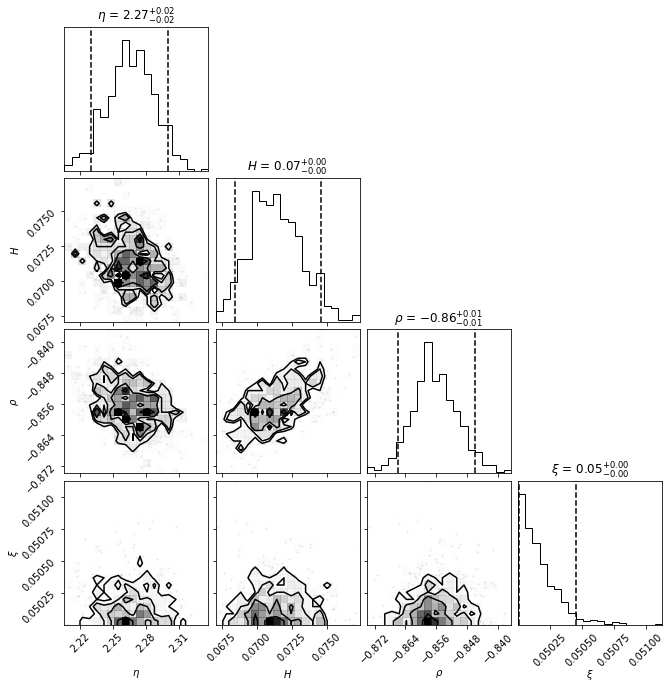

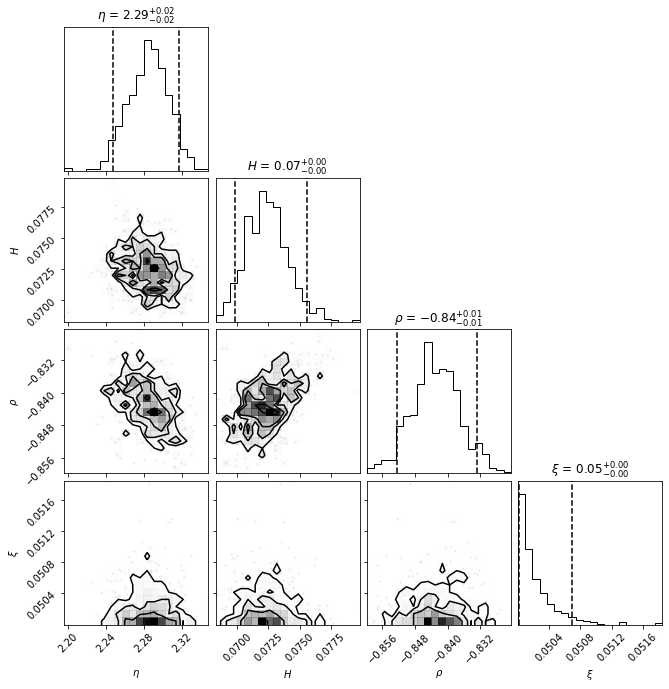

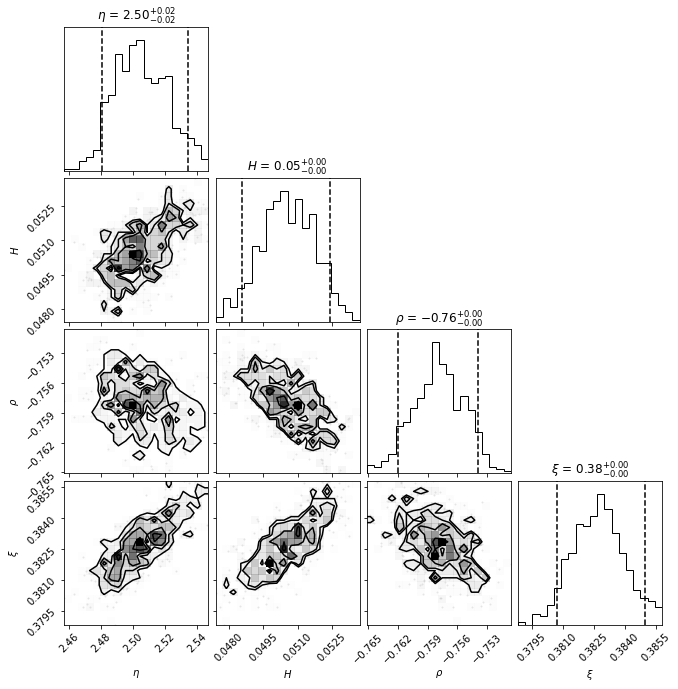

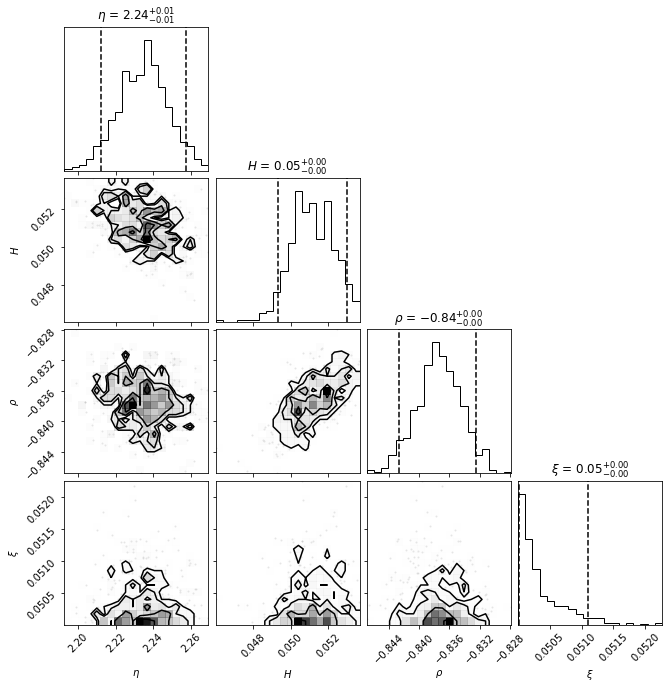

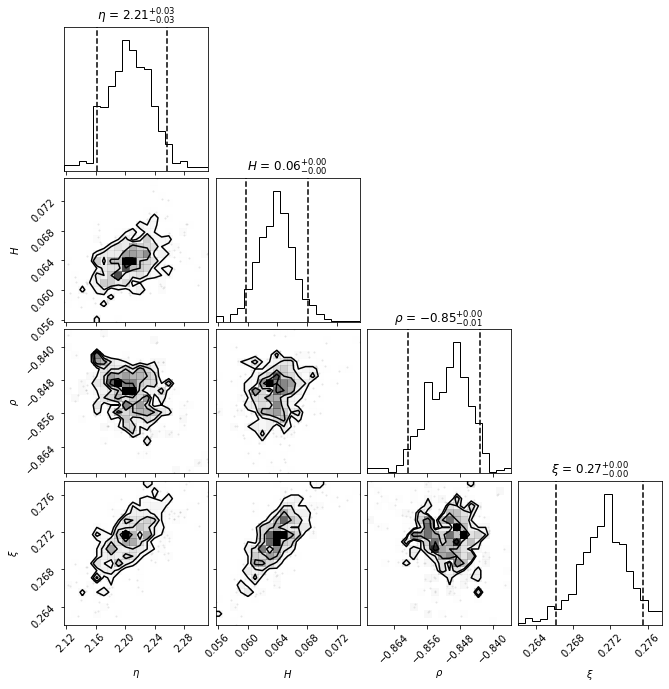

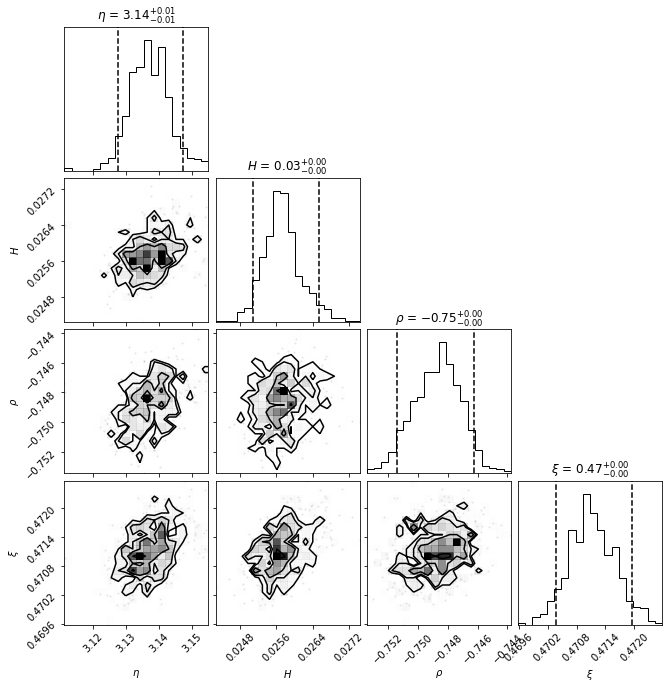

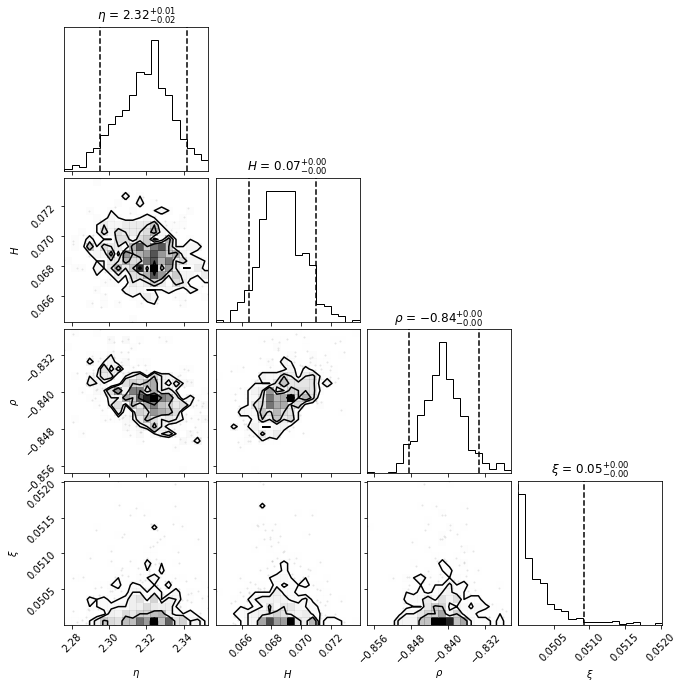

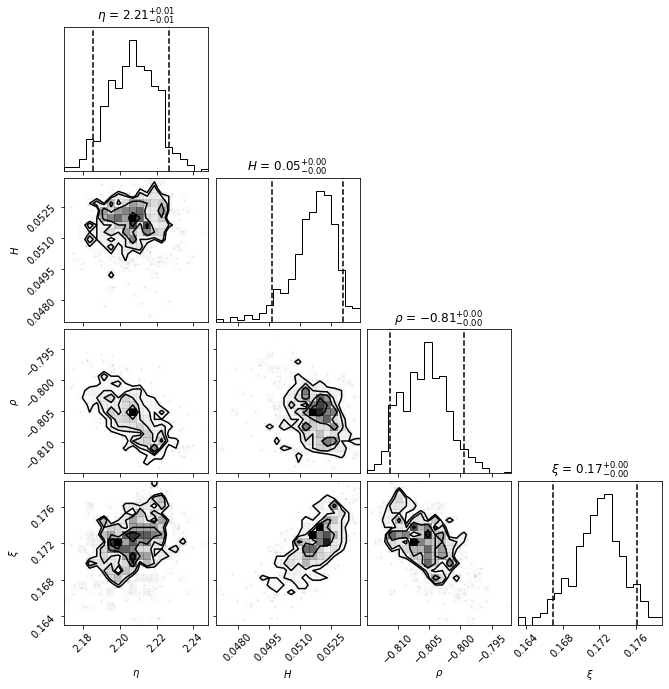

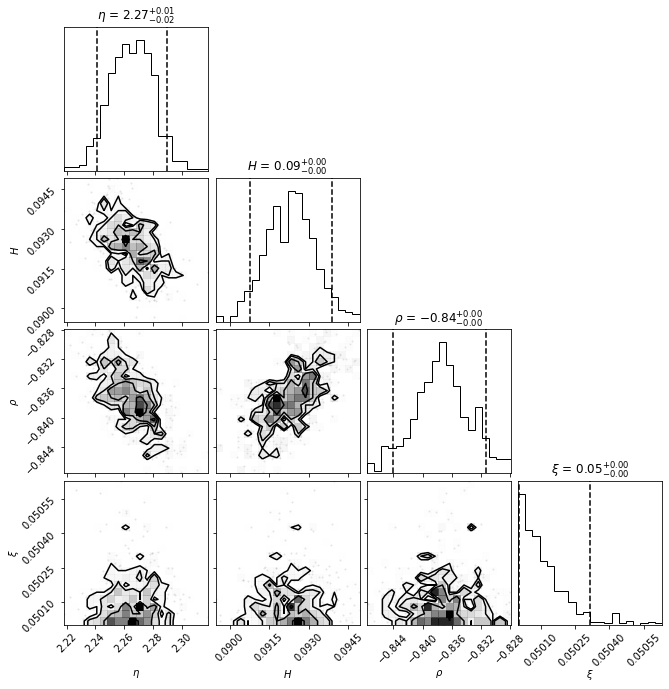

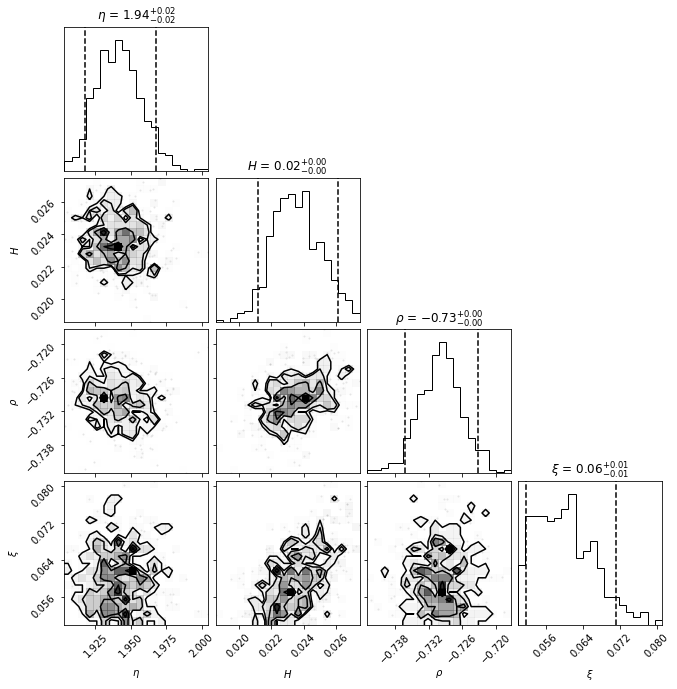

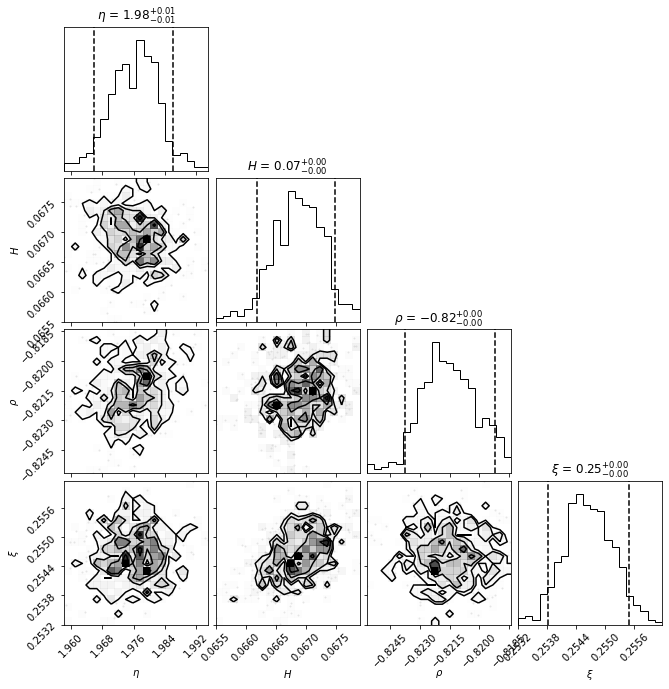

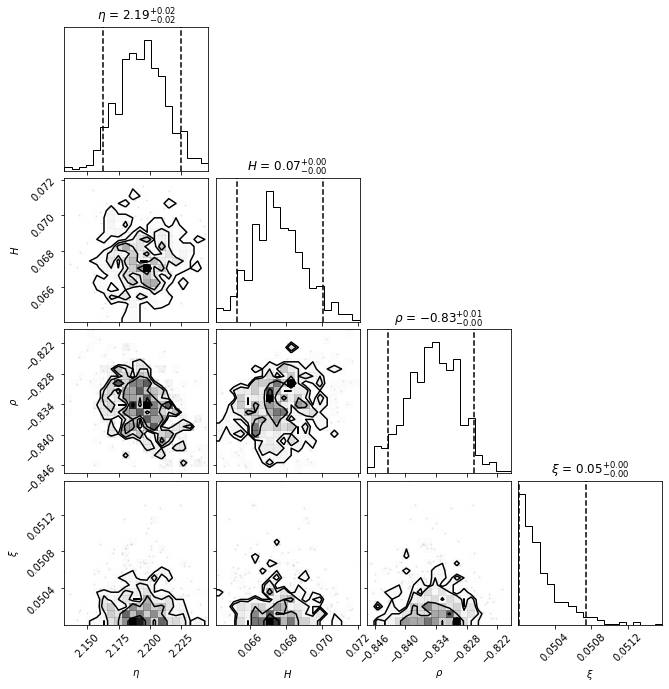

In [3]:
main()